In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
import h5py




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
pad = n//8
npos= 18*18
z1c = -20.1e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = 6144+2*pad
show = True

flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'
print(voxelsize)

4.769839921875e-08


## Read data

(21, 2048, 2048)
(1, 324, 2048, 2048)


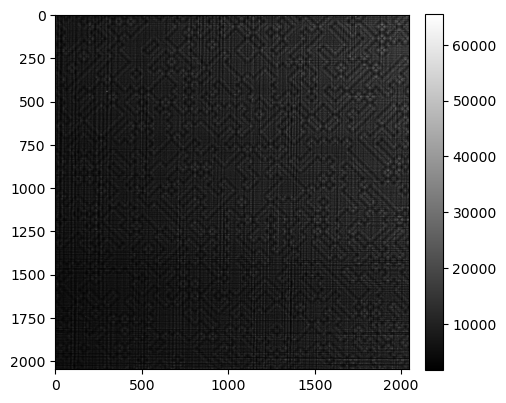

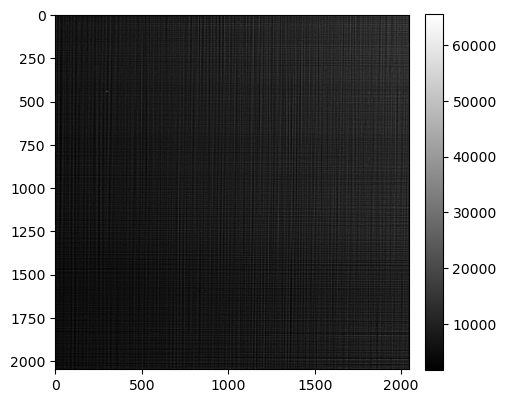

(20, 2048, 2048)


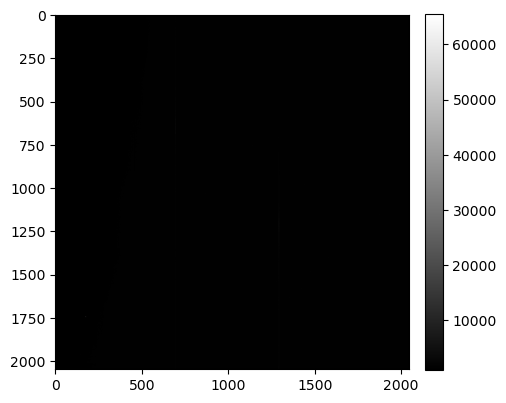

In [3]:
# with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp9x9_02/code2um_nfpx9_020000.h5') as fid:
#     data0 = fid['/entry_0000/measurement/data'][:].astype('float32')
# with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp9x9_02/ref_0000.h5') as fid:
#     ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
# with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp9x9_02/dark_0000.h5') as fid:
#     dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')

with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/code2um_nfp18x18_010000.h5') as fid:
    data0 = fid['/entry_0000/measurement/data'][:].astype('float32')
    
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/code2um_nfp18x18_01/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')

print(ref0.shape)
data0 = data0[np.newaxis]



shifts_code0 = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[np.newaxis,:,::-1]
shifts_code0 = shifts_code0/voxelsize*1e-6
print(data0.shape)
mshow(data0[0,0],show)
mshow(ref0[0],show)
print(dark0.shape)
mshow(dark0[0],show)

In [4]:
data = data0.copy()
ref = ref0.copy()
dark = dark0.copy()
for k in range(npos):
    radius = 7
    threshold = 20000
    data[:,k] = remove_outliers(data[:,k], radius, threshold)
ref[:] = remove_outliers(ref[:], radius, threshold)     
dark[:] = remove_outliers(dark[:], radius, threshold)     

# data[data<=0] = 0
# ref[ref<=0] = 0

data/=np.mean(ref)
dark/=np.mean(ref)
ref/=np.mean(ref)

rdata0 = (data-np.mean(dark,axis=0))/(np.mean(ref,axis=0)-np.mean(dark,axis=0))



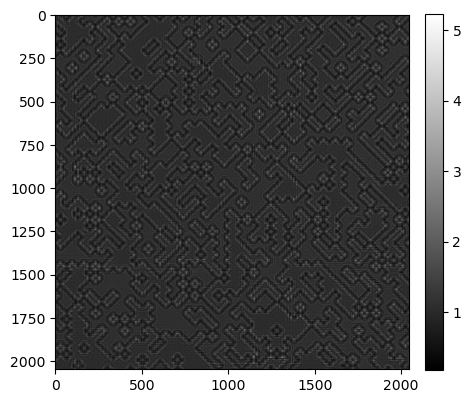

In [5]:
mshow(rdata0[0,0],show)

In [6]:
print(rdata0.shape,shifts_code0.shape)
np.save('rdata',rdata0[0,:19])
np.save('shifts_code',shifts_code0[0,:19])


(1, 324, 2048, 2048) (1, 324, 2)


(1, 324, 2)


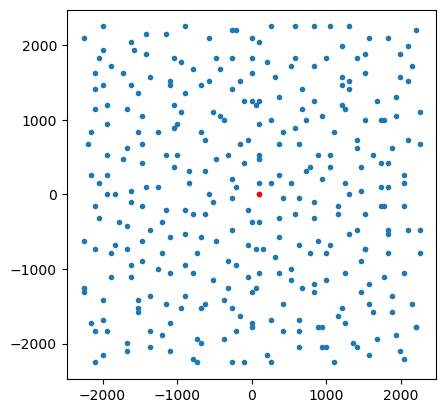

[[104.82532081   0.        ]]


In [7]:
print(shifts_code0.shape)
ipos = npos//2+9
plt.plot(shifts_code0[0,:,0],shifts_code0[0,:,1],'.')
plt.plot(shifts_code0[0,ipos,0],shifts_code0[0,ipos,1],'r.')

plt.axis('square')
plt.show()
print(shifts_code0[:,ipos])

In [19]:
from skimage.registration import phase_cross_correlation
import scipy.ndimage as ndimage
rdata = rdata0.copy()
shifts_code = shifts_code0.copy()
shifts_code[:,:,0]*=-1

shifts_relative = shifts_code.copy()*0
    

frame = 10
zoom = 100

def my_phase_corr(d1, d2, zoom=1):
    image_product = np.fft.fft2(d1) * np.fft.fft2(d2).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    ind = np.unravel_index(np.argmax(cc_image.real, axis=None), cc_image.real.shape)
    frame = 10
    # cropimg = cc_image[ind[0]-frame//2:ind[0]+frame//2, ind[1]-frame//2:ind[1]+frame//2]
    # zoomimg = ndimage.zoom(cropimg.real, zoom, order=5)
    # ind2 = np.unravel_index(np.argmax(zoomimg, axis=None), zoomimg.shape)
    shifts = np.subtract(ind,d1.shape[-1]//2) #+ np.subtract(np.divide(ind2, zoom), frame // 2)
    return shifts

    
for k in range(0,npos-1):     
    rdata = rdata0.copy()
    shifts_relative[0,k]=my_phase_corr(rdata[0,k],rdata[0,k+1],100)
    print(k,shifts_relative[0,k])
    rdata[:,k] = ST(rdata[:,k],shifts_relative[:,k])
    # mshow_complex(rdata[0,k,:c,:c]+1j*rdata[0,k+1,:c,:c],show,vmax=3)
    # mshow(rdata[0,k]-rdata[0,k+1],show,vmax=1)
np.save('shifts_relative',shifts_relative)    


0 [ -6. 434.]


/tmp/ipykernel_1291506/1865358904.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  rdata[:,k] = ST(rdata[:,k],shifts_relative[:,k])


1 [ 54. 125.]
2 [113. 468.]
3 [ 0. 55.]
4 [-121.  450.]


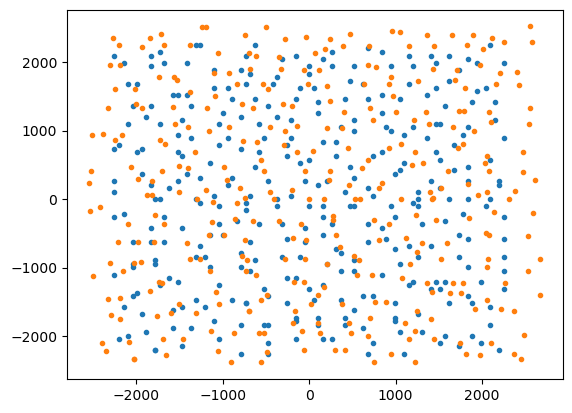

[[[ 2044.0937557    157.23798121]
  [ 2044.0937557   -157.23798121]
  [ 2096.5064161   -471.71394362]
  [ 2253.74439731  -471.71394362]
  [ 2253.74439731  -786.18990604]
  [ 2044.0937557  -1048.25320805]
  [ 2148.91907651 -1467.55449127]
  [ 2201.33173691 -1782.03045369]
  [ 2201.33173691 -1782.03045369]
  [ 2044.0937557  -2201.33173691]]]
[[[ 2208.   300.]
  [ 2209.   -54.]
  [ 2232.  -492.]
  [ 2382.  -560.]
  [ 2384.  -907.]
  [ 2210. -1054.]
  [ 2277. -1654.]
  [ 2329. -2025.]
  [ 2329. -2025.]
  [ 2211. -2350.]]]


: 

In [10]:
shifts_code = shifts_code0.copy()
shifts_code[:,:,0]*=-1
shifts_relative = -np.load('shifts_relative.npy')
shifts_code_new = shifts_code*0
for k in range(ipos):
    shifts_code_new[:,k] = np.sum(shifts_relative[:,k:ipos],axis=1) 
shifts_code_new[:,ipos] = shifts_code[:,ipos]
for k in range(ipos,npos):
    shifts_code_new[:,k] = np.sum(-shifts_relative[:,ipos:k],axis=1)

# shifts_code_new=shifts_code[:,ipos]
# shifts_code_new[:,:,1]-=100
# shifts_code_new[:,:,0]-=60

# shifts_code_new*=0.92
plt.plot(shifts_code[0,:,1],shifts_code[0,:,0],'.')
plt.plot(shifts_code_new[0,:,1],shifts_code_new[0,:,0],'.')
# plt.plot(shifts_relative[0,:,1],shifts_relative[0,:,0],'.')

# plt.plot(shifts_code_new[0],'
plt.show()
# print(shifts_code[:,:10])

# print(shifts_code_new[:,:10])
# print(voxelsize*0.92)

#back to original shape
shifts_code_new[:,:,0]*=-1
shifts_code0 = np.loadtxt(f'/data/vnikitin/ESRF/ID16A/20240924/positions/shifts_code_nfp18x18ordered.txt')[np.newaxis,:,::-1]
shifts_code0 = shifts_code0/voxelsize*1e-6
print(shifts_code0[:,-10:])
print(shifts_code_new[:,-10:])

np.save('shifts_code_new.npy',shifts_code_new[:,:,::-1])
